Create a class to hold our RBFN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split


class RBF:
    def __init__(self, n_inputs, n_hidden, n_outputs, centers, widths, verbose=False):
        """
        Parameters
        ----------
        n_inputs: int
            number of input nodes
        n_hidden: int
            number of rbf nodes
        n_outputs: int
            number output nodes
        centers: (1xn_hidden) array
            rbf function centers
        widths: (1xn_hidden) array
            rbf widths / std_dev
        """
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.centers = centers
        self.widths = widths
        self.verbose = verbose
        weight_init_range = 0.5
        self.weights = np.random.uniform(-weight_init_range, weight_init_range, (n_hidden, n_outputs))

    def gauss_kernel_func(self, x):
        """
        Applies the gauss kernel with the instantiated widths and centers for all rbf nodes to the single input.
        Returns the output of each rbf node on the single input.

        Parameters
        ----------
        x: np.array (n_inputs, )
            an input from the series of inputs
        """
        return np.exp((-1*(np.linalg.norm(x-self.centers, axis=1)**2)/(2*self.widths**2)))

    def inference(self, x):
        """
        Takes a set of input data and applies the gauss kernel function on them, then does the weighted summation
        to obtain network outputs of shape (n_input_data, n_output)

        Parameters
        ----------
        x: np.array (n_input_data, n_inputs)
        """
        if self.verbose:
            print('====INFERENCE====')
            
        activities = []
        for input_val in x:
            activity = self.gauss_kernel_func(input_val)
            activities.append(activity)
        activities = np.asarray(activities)

        # outputs = np.sum(self.weights * activities, axis=1)
        # outputs = np.asarray(outputs)
        outputs = activities @ self.weights
        return outputs

    def forward(self, x):
        """
        Takes a set of input data and applies the gauss kernel function on them, then does the weighted summation
        to obtain network outputs of shape (n_input_data, n_output).
        Differs from self.inference because here we store the inputs, activities, and output to self variables that
        are used during inference.

        Parameters
        ----------
        x: np.array (n_input_data, n_inputs)
        """
        if self.verbose:
            print('====FORWARD=====')
        self.input = x

        self.activities = []
        for input_val in self.input:
            activity = self.gauss_kernel_func(input_val)
            self.activities.append(activity)
        self.activities = np.asarray(self.activities)

        self.output = self.activities @ self.weights
        
        if self.verbose:
            print('weights| (n_hiddenxn_output): ', self.weights.shape)
            print('input| (n_samplesxn_input): ', self.input.shape)
            print('activities| (n_samplesxn_hidden): ', self.activities.shape)
            print('output: | (n_hiddenx1)', self.output.shape)
        return self.output

    def backward(self, target_output):
        """
        Run this after running self.forward where we determine and store our series of activities.
        Accepts the matching target outputs for the inputs used during the forward pass. Performs
        the matrix (pseudo)inverse using the series of activities and target output obtain the output weights.
        Parameters
        ----------
        target_output: np.array (n_input_data, n_outputs)
            the target outputs of the inputs used during self.forward

        """
        if target_output.ndim == 1:
            target_output = np.expand_dims(target_output, 1)
            
        if self.verbose:
            print('====BACKWARD===')
            print('activities series: ', self.activities.shape)
            print('target_output series: ', target_output.shape)
            print('weights: ', self.weights.shape)
        # normal inverse
        # if self.n_hidden >= len(self.input):
        if np.linalg.matrix_rank(self.activities) >= target_output.shape[0]:
            if self.verbose:
                print('Inverse')
            # np.savez_compressed('test_data.npz', activities=self.activities, weights=self.weights, targets=target_output)
            self.weights = np.linalg.inv(self.activities) @ target_output

        # pseudo inverse
        else:
            if self.verbose:
                print('Pseudo-inverse')
            self.weights = np.linalg.pinv(self.activities) @ target_output

        # print('activities: ', self.activities[:10, :10])
        # sanity_check = self.activities @ self.weights
        # print('target_out: ', target_output[:10])
        # print('sanity check: ', sanity_check[:10])

Define the function we're trying to model

In [2]:
# The function we're trying to model
def ground_truth_func(x):
    if x[0]**2 + x[1]**2 <= 1:
        return 1
    else:
        return -1

Generate our target inputs using 
<br>`xi = -2 + 0.2i`
<br>`xj = -2 + 0.2j`
<br>`where i = 0, 1,..., 20`
<br>`where i = 0, 1,..., 20`
then calculate the corresponding outputs using our target function

In [3]:
#=========================================SETUP
# Generate our input and target data
x = np.ones((21, 21, 2))
for ii in range(0, x.shape[0]):
    for jj in range(0, x.shape[1]):
        xi = -2 + 0.2*ii
        xj = -2 + 0.2*jj
        x[ii, jj] = [xi, xj]

print('input original shape: ', np.asarray(x).shape)
x = x.reshape(np.prod(x.shape[:2]), x.shape[-1])
print('input flattened shape: ', np.asarray(x).shape)

# calculate the ground truth using the known function we're modelling
y = np.zeros(x.shape[0])
for ii, input_val in enumerate(x):
    y[ii] = ground_truth_func(input_val)

print('target output shape: ', np.asarray(y).shape)

input original shape:  (21, 21, 2)
input flattened shape:  (441, 2)
target output shape:  (441,)


Plot our inputs and their corresponding outputs on a 3d scatterplot as a sanity check.

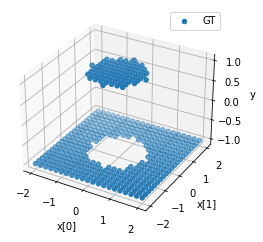

In [4]:
plt.figure()
a1 = plt.subplot(111, projection='3d')
a1.scatter(x[:, 0], x[:, 1], y, label='GT')
a1.set_xlabel('x[0]')
a1.set_ylabel('x[1]')
a1.set_zlabel('y')
plt.legend()
plt.show()

Split our data into a 80-20 train-test split

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=0)
print('train_data shape: ', train_data.shape)
print('test_data shape: ', test_data.shape)
print('train labels shape: ', train_labels.shape)
print('test labels shape: ', test_labels.shape)

train_data shape:  (352, 2)
test_data shape:  (89, 2)
train labels shape:  (352,)
test labels shape:  (89,)


# Train RBFN output weights

In [6]:
# Create our rbf network with the number of hidden node matches the number of input data points
# set our layer sizes
n_input = 2
n_hidden = train_data.shape[0]
n_output = 1

# set our width to 0.2 at first, we will vary it later
width = 0.2
widths = np.ones(n_hidden) * width

# set our centers to the training data
centers = train_data
print('widths: ', widths.shape)
print('centers: ', centers.shape)

# Using training data as rbf centers
print('Creating RBFN with %i input, %i hidden, and %i output' % (n_input, n_hidden, n_output))
rbf = RBF(n_input, n_hidden, n_output, centers=centers, widths=widths)

widths:  (352,)
centers:  (352, 2)
Creating RBFN with 2 input, 352 hidden, and 1 output


Run the forward and backward pass on the training data to obtain our weights

In [7]:
# run forward and backward pass to get weights
train_out = rbf.forward(train_data)
print('train output shape: ', train_out.shape)
rbf.backward(train_labels)

train output shape:  (352, 1)


sanity check, this should match our data exactly if activities is invertable

In [8]:
train_inference_out = rbf.inference(train_data)
print('inference output shape: ', train_inference_out.shape)

inference output shape:  (352, 1)


As a sanity check, run the inference on the training data. Since our number of hidden dimensions matches the number of input data points, we should be able to perfectly model the input data. However, this will not hold if the set of activities is non-singular (ie. rank(activities) < activities.ndim)

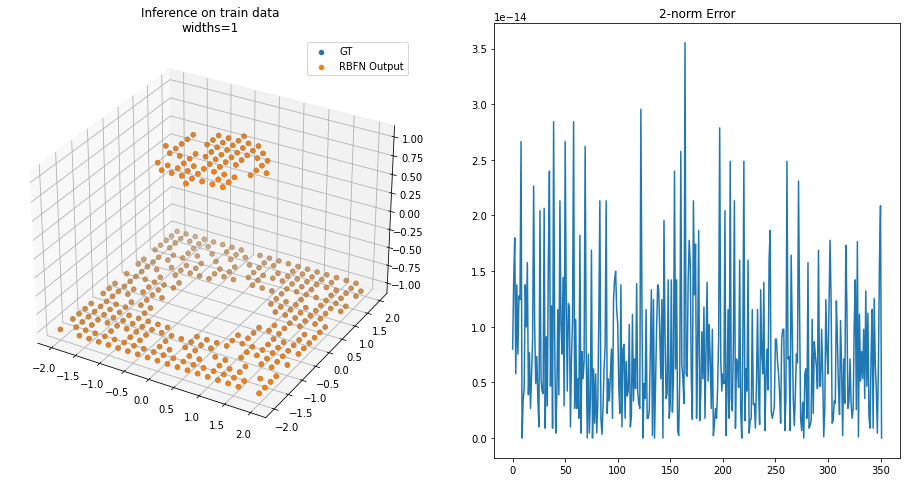

In [9]:
def plot_outputs_and_error(train_data, train_labels, x, y, title):
    plt.figure(figsize=(16, 8))
    # plot the actual data
    a1 = plt.subplot(121, projection='3d')
    a1.set_title(title)
    a1.scatter(train_data[:, 0], train_data[:, 1], train_labels, label='GT')
    a1.scatter(x[:, 0], x[:, 1], np.squeeze(y), label='RBFN Output')
    plt.legend()

    # plot the error
    a2 = plt.subplot(122)
    a2.set_title('2-norm Error')
    #test_out = np.squeeze(test_out)
    train_labels = np.reshape(train_labels, (len(train_labels), 1))

    a2.plot(np.linalg.norm(train_labels-y, axis=1))

    plt.show()
plot_outputs_and_error(train_data, train_labels, train_data, train_inference_out, 'Inference on train data\nwidths=1')

Since our inferred output on the training data is all zero (within numerical error of floating points), our model is correctly performing the RBFN. Now we can run the same test on our test data to see how the network performs.

# Part 1.

### Carry out the design of RBF NN based on Gaussian kernel functions with constant spread function and using all the points in the training set as centers of the RB functions. Compare the performance results (mean square error) as you vary the spread parameter while keeping it the same for all kernel functions. Discuss your findings.

test output shape:  (89, 1)


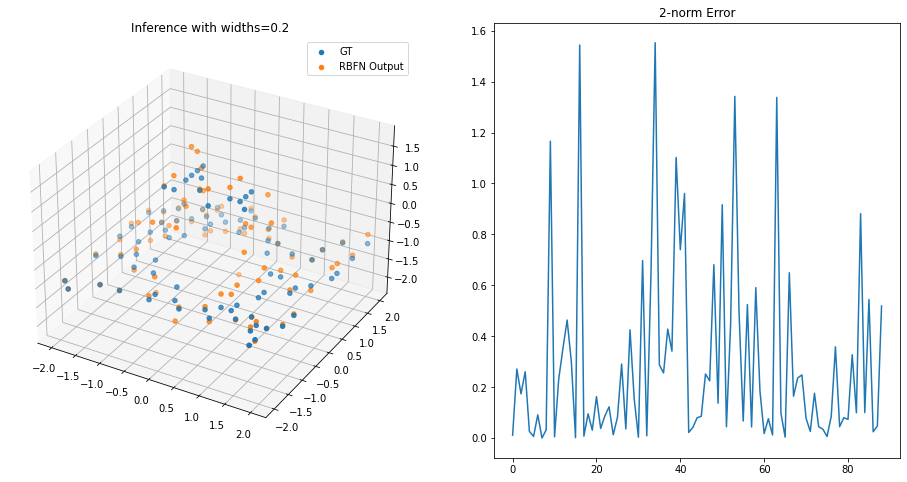

In [10]:
test_out = rbf.inference(test_data)
print('test output shape: ', test_out.shape)
plot_outputs_and_error(test_data, test_labels, test_data, test_out, 'Inference with widths=0.2')

Note that the above is with a constant width across all RBF nodes of 1. Now let's vary the width and see what happens.

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.1, centers=train_data


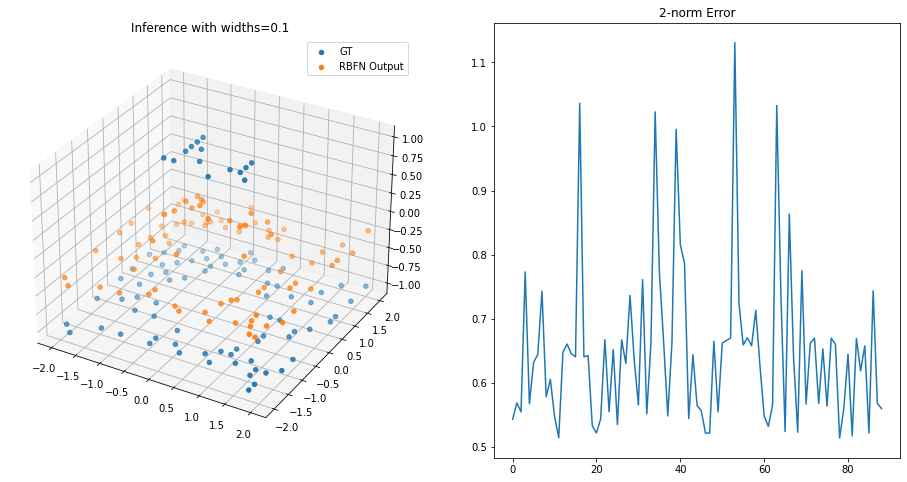

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.2, centers=train_data


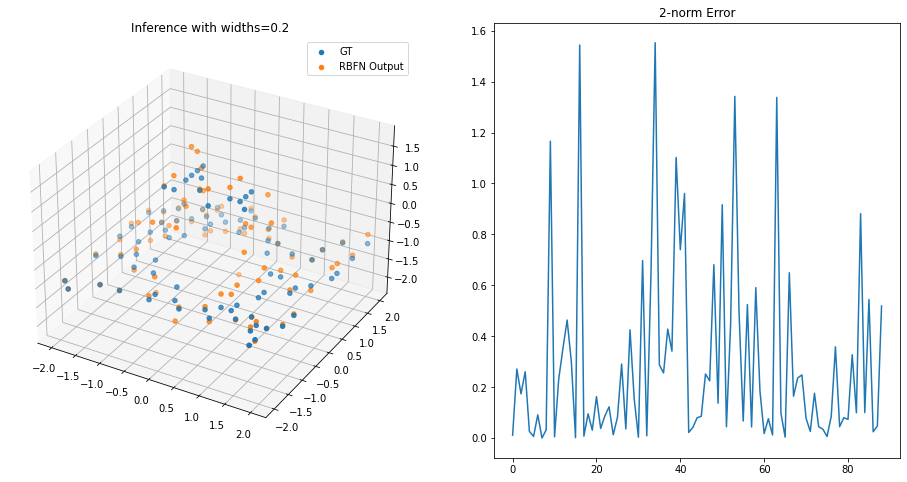

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.3, centers=train_data


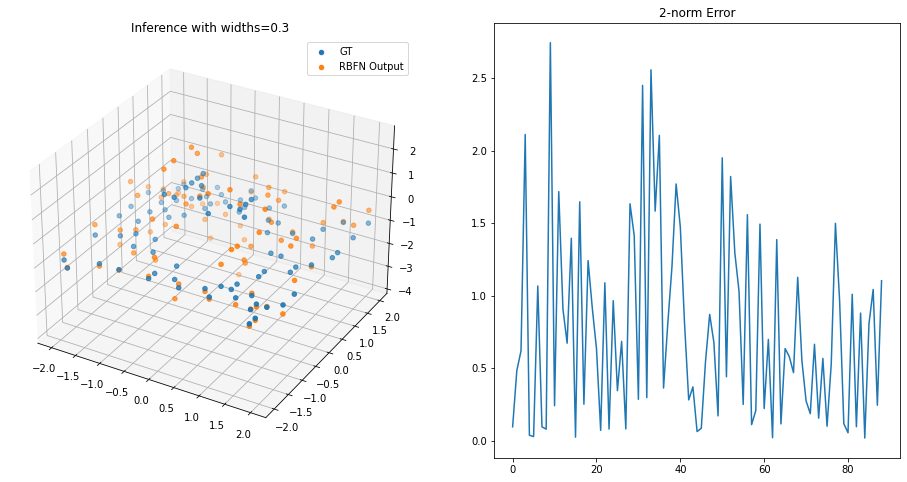

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.4, centers=train_data


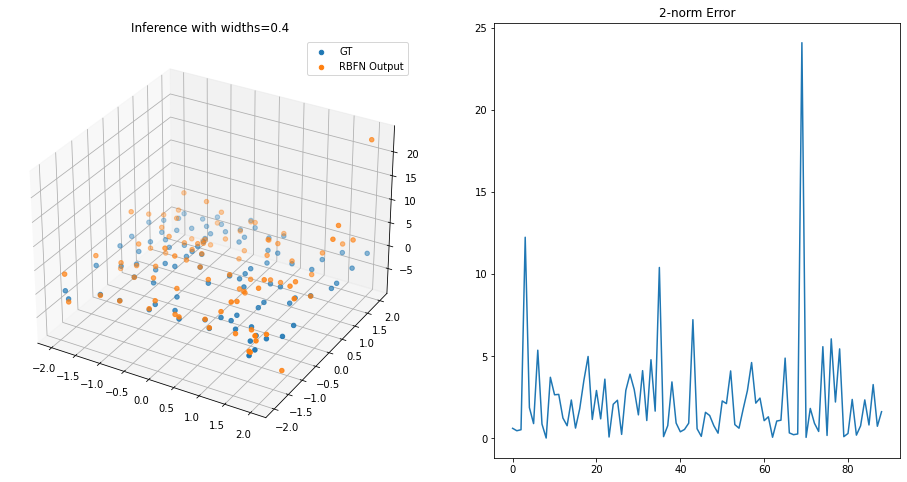

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.5, centers=train_data


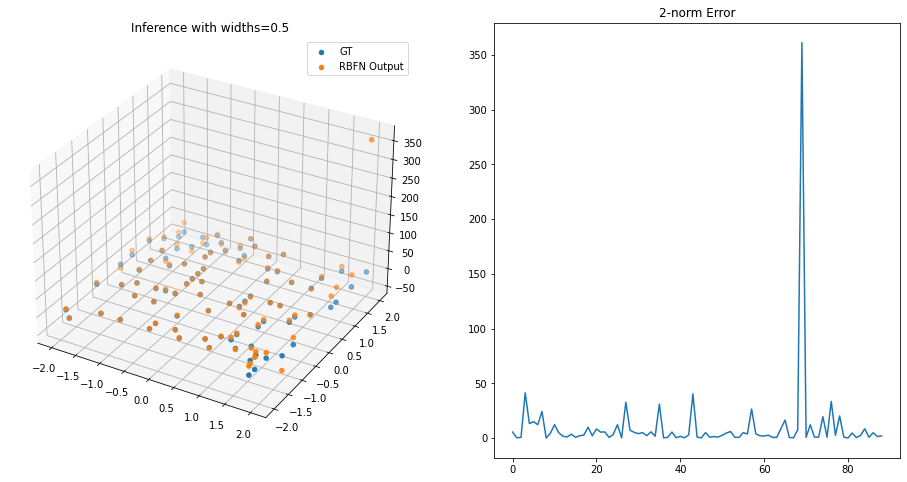

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.6, centers=train_data


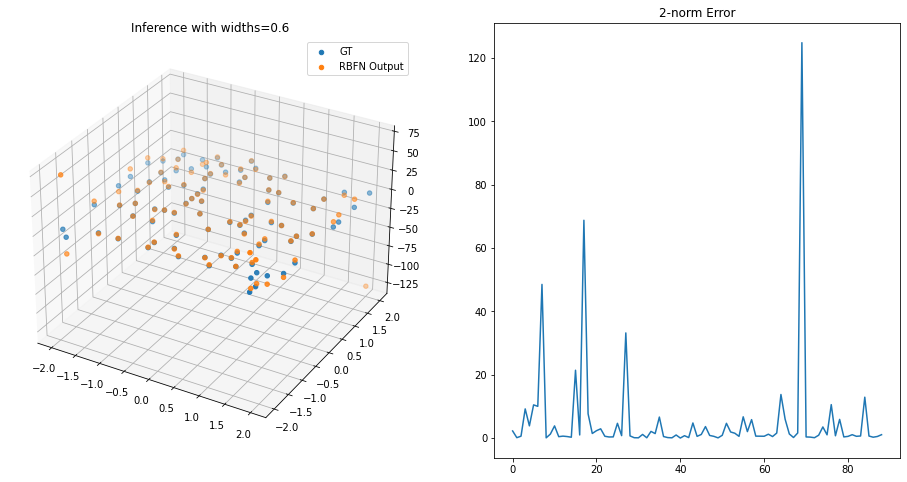

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.7, centers=train_data


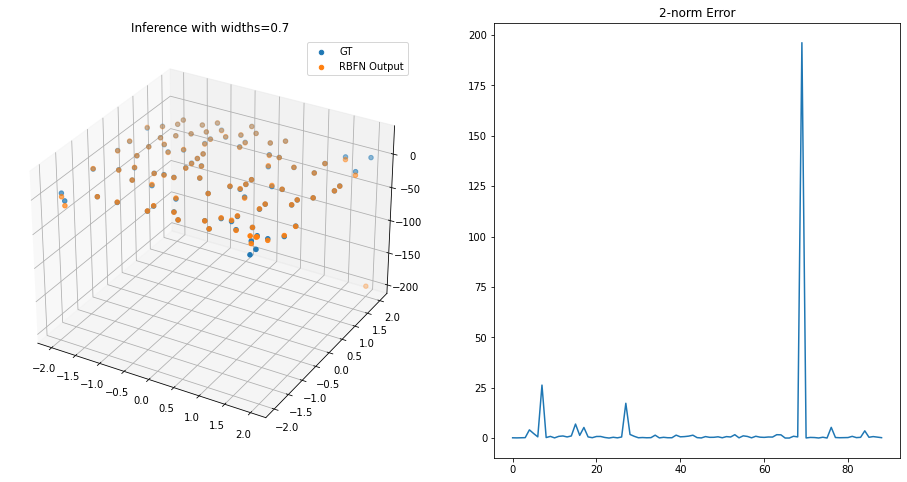

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.8, centers=train_data


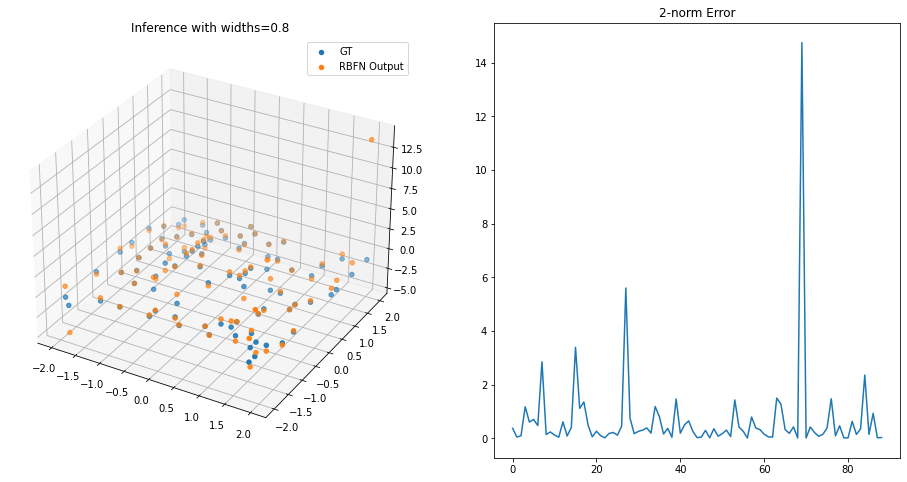

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=0.9, centers=train_data


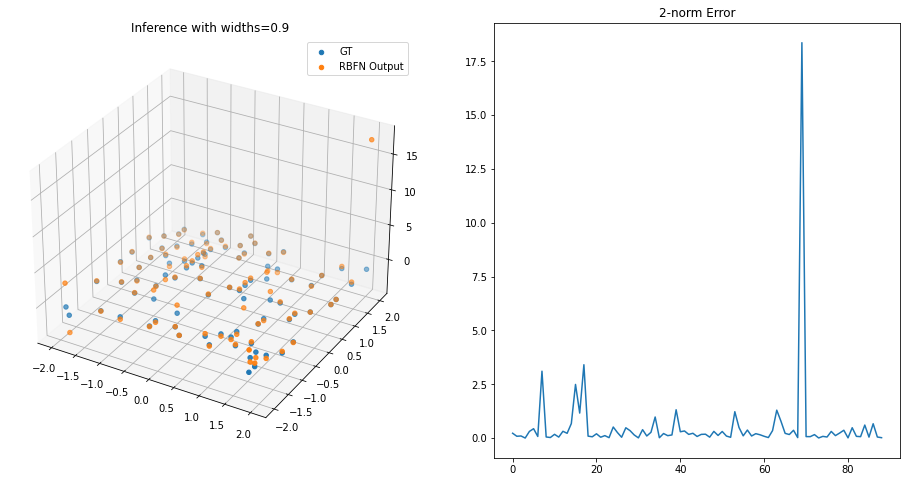

Testing RBFN with 2 input, 352 hidden, and 1 output, widths=1.0, centers=train_data


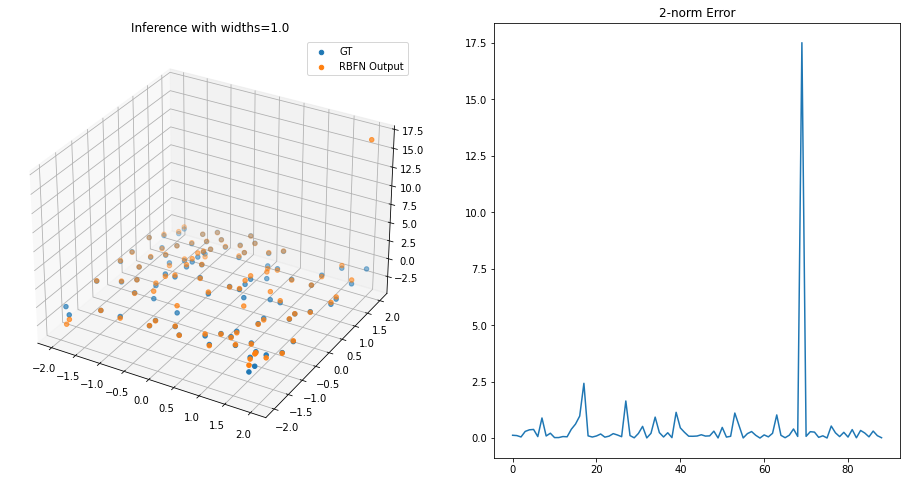

In [11]:
centers = train_data
width_vals = np.linspace(0.1, 1, 10)
for width in width_vals:
    widths = np.ones(n_hidden) * width

    # Using training data as rbf centers
    print('Testing RBFN with %i input, %i hidden, and %i output, widths=%.1f, centers=train_data' % (
        (n_input, n_hidden, n_output, width))
    )
    rbf = RBF(
        n_inputs=2,
        n_hidden=train_data.shape[0],
        n_outputs=1,
        centers=centers,
        widths=widths)

    # run forward and backward pass to get weights
    train_out = rbf.forward(train_data)
    rbf.backward(train_labels)
    test_out = rbf.inference(test_data)
    plot_outputs_and_error(test_data, test_labels, test_data, test_out, "Inference with widths=%.1f" % width)

When the spread matches the spread of our data (0.2) we get the closest match

# Part 2. 

## Perform the design of the RBF NN, using this time only 150 centers, choosing the centers using two approaches:<br> a) Randomly select the centers from the input data.

centers shape:  (150, 2)
Testing RBFN with 2 input, 150 hidden, and 1 output, widths=0.2, centers=train_data


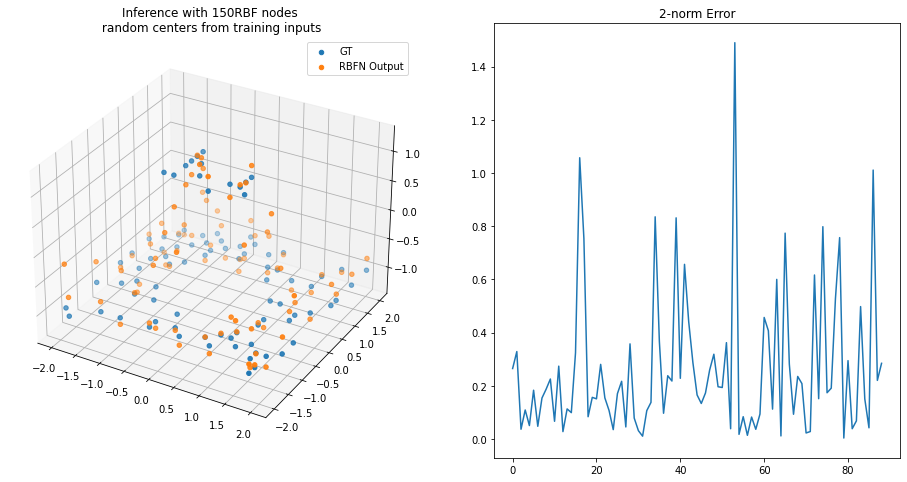

In [12]:
indices = np.random.choice(np.arange(0, train_data.shape[0]), 150, replace=False)
centers = train_data[indices]
print('centers shape: ', centers.shape)
width = 0.2
widths = np.ones(centers.shape[0]) * width

# Using training data as rbf centers
print('Testing RBFN with %i input, %i hidden, and %i output, widths=%.1f, centers=train_data' % (
    (n_input, centers.shape[0], n_output, width))
)
rbf = RBF(
    n_inputs=2,
    n_hidden=centers.shape[0],
    n_outputs=1,
    centers=centers,
    widths=widths)

# run forward and backward pass to get weights
train_out = rbf.forward(train_data)
rbf.backward(train_labels)
test_out = rbf.inference(test_data)
plot_outputs_and_error(test_data, test_labels, test_data, test_out, "Inference with 150RBF nodes\n random centers from training inputs")

It is clear the error is larger with fewer nodes to model the input. The matrix inversion now has to use the pseudo-inverse since our activities series matrix is non-singular.

## b) Use K-Means algorithm to find the centers. You can use a Kmeans function defined in sklearn <br>(https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

First we have to calculate our centers through clustering.

Note need to make this (150,2)

In [35]:
#Do sci-kit learn stuff to get  clusters  training data into 150 points for our centers
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=150, random_state = 0)
kmeans.fit(train_data)

centers = kmeans.cluster_centers_

centers shape:  (150, 2)
Testing RBFN with 2 input, 150 hidden, and 1 output, widths=0.2, centers=train_data


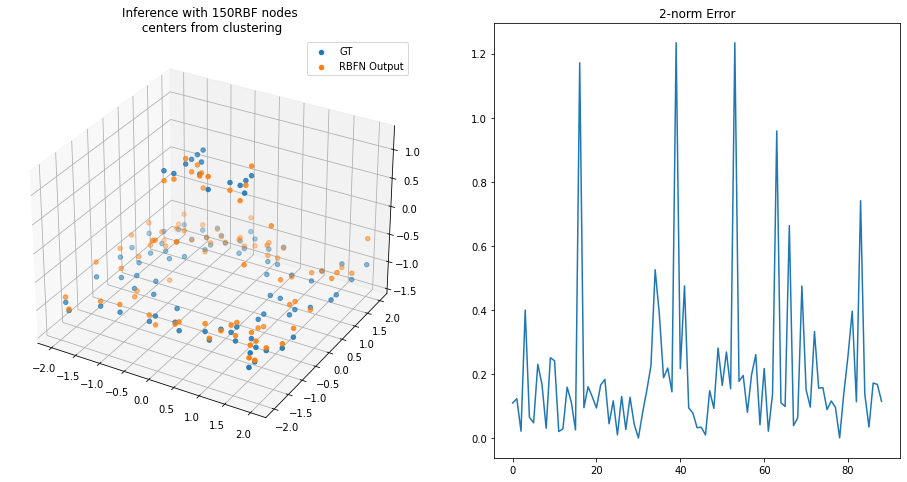

In [44]:
print('centers shape: ', centers.shape)
width = 0.2
widths = np.ones(centers.shape[0]) * width

# Using training data as rbf centers
print('Testing RBFN with %i input, %i hidden, and %i output, widths=%.1f, centers=train_data' % (
    (n_input, centers.shape[0], n_output, width))
)

rbf = RBF(
    n_inputs=2,
    n_hidden=centers.shape[0],
    n_outputs=1,
    centers=centers,
    widths=widths)

# run forward and backward pass to get weights
train_out = rbf.forward(train_data)
rbf.backward(train_labels)
test_out = rbf.inference(test_data)
plot_outputs_and_error(test_data, test_labels, test_data, test_out, "Inference with 150RBF nodes\n centers from clustering")

The resulting error for using the K-means clustering to find all the centers, provides an overall better error response to our 2-norm when the width is fixed. The worse case in the random selection and better performance with respect to the best found width in part 1